# Backtesting

In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import bt

In [413]:
ticker_symbol = "ZN=F"
time_period = '15y'
df = yf.Ticker(ticker_symbol).history(period = time_period)
df.drop(columns = ['Dividends', 'Stock Splits'], inplace = True)

In [414]:
df['Return'] = df["Close"].pct_change()
df['Day_of_Month'] = df.index.day # Add column with day of month

In [415]:
df.head(3)

,Open,High,Low,Close,Volume,Return,Day_of_Month
Date,,,,,,,
2009-12-30 00:00:00-05:00,115.640625,115.859375,115.562500,115.843750,362111,NaN,30
2009-12-31 00:00:00-05:00,115.765625,115.765625,114.890625,115.453125,315230,-0.003372,31
2010-01-04 00:00:00-05:00,115.187500,115.734375,114.968750,115.531250,611675,0.000677,4


In [416]:
df1 = df.groupby('Day_of_Month')['Return'].mean()

Text(0.5, 1.0, 'ZN=F Mean Return by Day of Month')

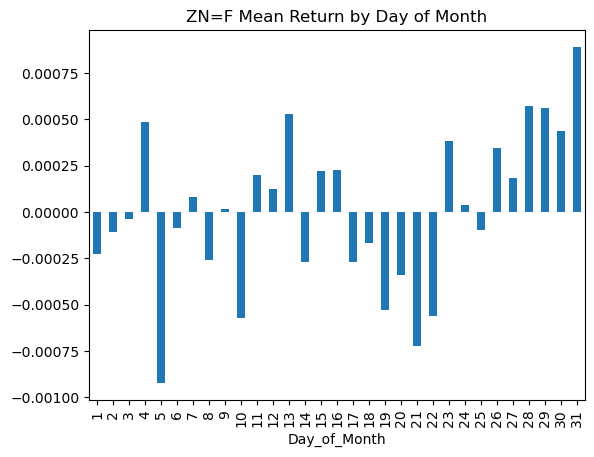

In [417]:
df1.plot(kind = 'bar')
plt.title(f"{ticker_symbol} Mean Return by Day of Month")

### Start bt Backtesting

The following image can be used as a base case for all backtests, this is a simple starting point which is a buy and hold strategy:

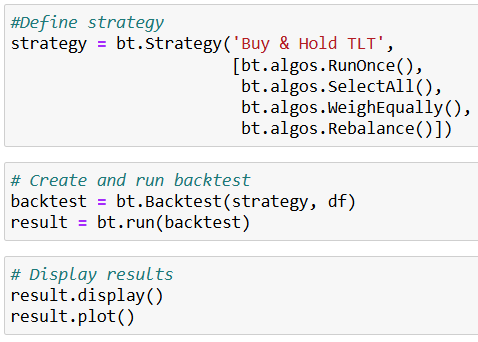

###### I start first with the logic or signal for the strategy, this is seperate from the actual bt code

In [418]:
# logic for identifying the last 5 trading days of each month
df['Last5Days'] = df.index.to_series().apply(
    lambda x: pd.Timestamp(x).is_month_end or 
              pd.Timestamp(x + pd.offsets.BDay(1)).is_month_end or 
              pd.Timestamp(x + pd.offsets.BDay(2)).is_month_end or 
              pd.Timestamp(x + pd.offsets.BDay(3)).is_month_end or 
              pd.Timestamp(x + pd.offsets.BDay(4)).is_month_end
)

In [419]:
df['LongDays'] = df.index.to_series().apply(
    lambda x: 5 <= x.day <= 12
)


In [420]:
# Create price dataframe with only closing price columns
price_data = df[['Close']] # make sure to use 2 square brackets idk why tho

In [427]:
# Prepare the signal DataFrame (align with Close column)
signal_df = pd.DataFrame(index=price_data.index, data={'Close': df['Last5Days']})

###### Now begins the bt code for defining and running the backtest

In [428]:
# Define the strategy
strategy = bt.Strategy('Long ZN Last 5 Days of Month',
                       [bt.algos.RunDaily(),                   # Run logic daily
                        bt.algos.SelectWhere(signal_df),       # Use DataFrame with boolean variables (true/false) for signal
                        bt.algos.WeighEqually(),               # Allocate equally
                        bt.algos.Rebalance()])  

In [429]:
# Define the buy-and-hold strategy
buy_and_hold = bt.Strategy('ZN',
                           [bt.algos.RunOnce(),                   
                            bt.algos.SelectAll(),                 
                            bt.algos.WeighEqually(),            
                            bt.algos.Rebalance()]) 

In [430]:
# Create and run backtest
backtest = bt.Backtest(strategy, price_data) #bt requires a dataframe with just one column of prices to run (price_data)

# Create backtest for buy and hold
backtest_buy_and_hold = bt.Backtest(buy_and_hold, price_data)

In [431]:
# Run both backtests
result = bt.run(backtest, backtest_buy_and_hold)

Stat                 Long ZN Last 5 Days of Month    ZN
-------------------  ------------------------------  ----------
Start                2009-12-29                      2009-12-29
End                  2024-12-30                      2024-12-30
Risk-free rate       0.00%                           0.00%

Total Return         27.58%                          -5.96%
Daily Sharpe         0.75                            -0.05
Daily Sortino        1.24                            -0.08
CAGR                 1.64%                           -0.41%
Max Drawdown         -2.64%                          -24.87%
Calmar Ratio         0.62                            -0.02

MTD                  0.26%                           -1.87%
3m                   -0.32%                          -4.68%
6m                   0.93%                           -0.95%
YTD                  4.21%                           -3.50%
1Y                   4.21%                           -3.50%
3Y (ann.)            3.42%       

<AxesSubplot:title={'center':'Equity Progression'}>

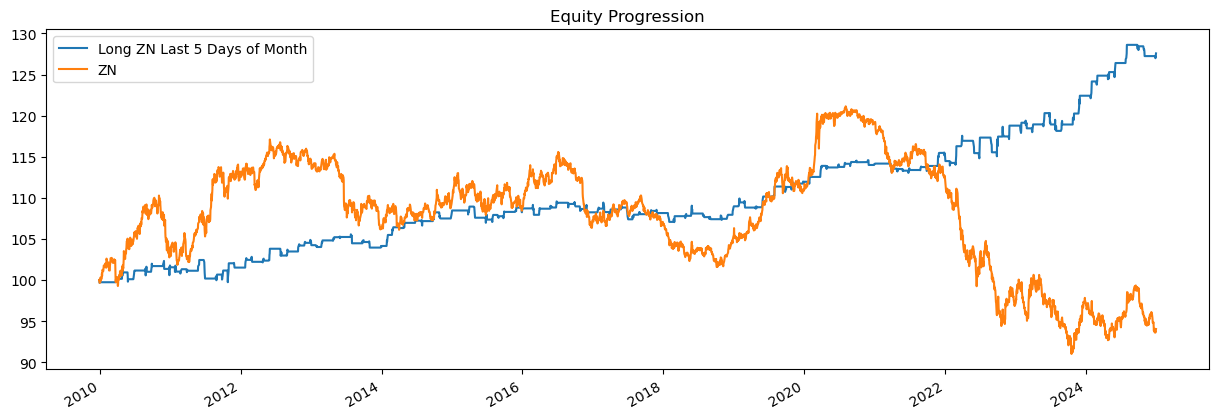

In [432]:
# Display results
result.display()
result.plot()